In [74]:
import networkx as nx

from factorio_design_compiler.fdc_utils import bp_string_to_json
import numpy as np
import pandas as pd

In [2]:
basic_belts = bp_string_to_json('0eJydldFugyAUht/lXNMGUGvxcq+xNI22ZCFRNEiXGeO7D+fWLDmSerxTge+cfPLDCFX90J0z1kMxgrm1tofifYTefNiynr/5odNQgPG6AQa2bOY370rbd63zh0rXHiYGxt71FxRiujDQ1htv9EJaX8Gga/swqbVzjbDwkBwzBkN4kMcs8O7G6dsyLn+Jw9U+mkq7uQrbDhZRcIrAkgDmUe4JcRMCV0a5HHFTioinYf7acEYByygYGz5RwJzQcb7n1yEuVnzeo1i87lftMYy4WLDge8KBwHgPC0rq+HYRghK6aL8rIiih++t3y+FDCZ0gcCmZi0duBUzJXPyQWNkRlMwlMRM4coKSuWjkVnaEmm+nn5us+HfxMfjUrl/knUWaK5mnUqlECQZ1GaqG2W/P2dP0DWvKW7E=')

In [3]:
# Get the actual design layout
basic_belts_entities = basic_belts.get('blueprint').get('entities')
basic_belts_entities

[{'name': 'transport-belt',
  'position': {'x': -3.5, 'y': -2.5},
  'direction': 2,
  'entity_number': 1},
 {'name': 'transport-belt',
  'position': {'x': -1.5, 'y': -2.5},
  'direction': 4,
  'entity_number': 2},
 {'name': 'transport-belt',
  'position': {'x': 0.5, 'y': -2.5},
  'direction': 6,
  'entity_number': 3},
 {'name': 'transport-belt',
  'position': {'x': 2.5, 'y': -2.5},
  'direction': 0,
  'entity_number': 4},
 {'name': 'transport-belt',
  'position': {'x': -3.5, 'y': -0.5},
  'direction': 2,
  'entity_number': 5},
 {'name': 'transport-belt',
  'position': {'x': -2.5, 'y': -0.5},
  'direction': 4,
  'entity_number': 6},
 {'name': 'transport-belt',
  'position': {'x': -0.5, 'y': -0.5},
  'direction': 2,
  'entity_number': 7},
 {'name': 'transport-belt',
  'position': {'x': 0.5, 'y': -0.5},
  'direction': 0,
  'entity_number': 8},
 {'name': 'transport-belt',
  'position': {'x': -3.5, 'y': 1.5},
  'direction': 2,
  'entity_number': 9},
 {'name': 'transport-belt',
  'position':

In [87]:
basic_belts_df = pd.DataFrame.from_dict(basic_belts_entities)
basic_belts_df = basic_belts_df[basic_belts_df.name == 'transport-belt']
basic_belts_df.drop('entity_number', axis=1, inplace=True, errors='ignore')

def get_position_int_x(d: dict) -> int:
    x_raw_float = d.get('x')
    x_int = int(x_raw_float * 2)
    return x_int

def get_position_int_y(d: dict) -> int:
    y_raw_float = d.get('y')
    y_int = int(y_raw_float * 2)
    return y_int

basic_belts_df['x'] = basic_belts_df.position.map(get_position_int_x)
basic_belts_df['y'] = basic_belts_df.position.map(get_position_int_y)
basic_belts_df.drop('position', axis=1, inplace=True, errors='ignore')
basic_belts_df['direction_we'] = ((basic_belts_df.direction // 2) % 2).astype(int)
basic_belts_df['direction_ns'] = ((basic_belts_df.direction // 2 + 1) % 2).astype(int)
basic_belts_df['direction_se'] = ((basic_belts_df.direction // 2) < 2).astype(int)
basic_belts_df['x_with_side'] = list(zip(
    basic_belts_df.x + basic_belts_df.direction_ns, basic_belts_df.x - basic_belts_df.direction_ns
))
basic_belts_df['y_with_side'] = list(zip(
    basic_belts_df.y + basic_belts_df.direction_we, basic_belts_df.y - basic_belts_df.direction_we
))
basic_belts_df = basic_belts_df.explode(column=['x_with_side', 'y_with_side'])
basic_belts_df.name = basic_belts_df.name + '-side'
basic_belts_df

,name,direction,x,y,direction_we,direction_ns,direction_se,x_with_side,y_with_side
0,transport-belt-side,2,-7,-5,1,0,1,-7,-4
0,transport-belt-side,2,-7,-5,1,0,1,-7,-6
1,transport-belt-side,4,-3,-5,0,1,0,-2,-5
1,transport-belt-side,4,-3,-5,0,1,0,-4,-5
2,transport-belt-side,6,1,-5,1,0,0,1,-4
2,transport-belt-side,6,1,-5,1,0,0,1,-6
3,transport-belt-side,0,5,-5,0,1,1,6,-5
3,transport-belt-side,0,5,-5,0,1,1,4,-5
4,transport-belt-side,2,-7,-1,1,0,1,-7,0
4,transport-belt-side,2,-7,-1,1,0,1,-7,-2


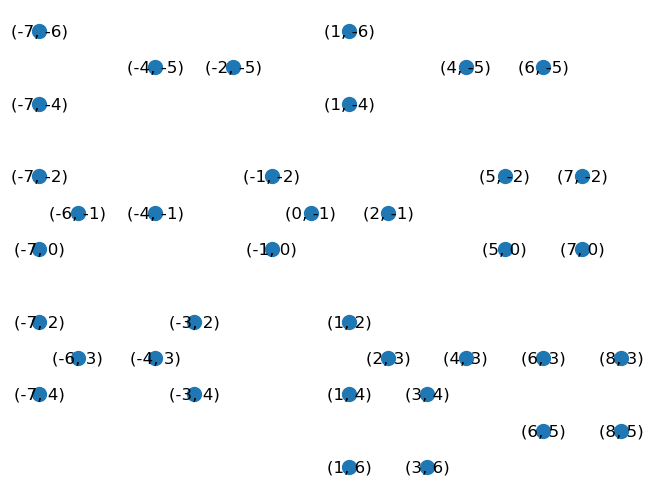

In [91]:
belts_graph = nx.DiGraph()
for i, row in basic_belts_df.iterrows():
    belts_graph.add_node(
        (row.x_with_side, row.y_with_side),
        x=row.x,
        y=row.y,
        pos=(row.x_with_side, -row.y_with_side)
    )
pos = nx.get_node_attributes(belts_graph, 'pos')
# nx.draw(belts_graph)
nx.draw(belts_graph, pos=pos, node_size=100, with_labels=True)

In [97]:
belts_graph.nodes

NodeView(((-7, -4), (-7, -6), (-2, -5), (-4, -5), (1, -4), (1, -6), (6, -5), (4, -5), (-7, 0), (-7, -2), (-4, -1), (-6, -1), (-1, 0), (-1, -2), (2, -1), (0, -1), (-7, 4), (-7, 2), (-4, 3), (-6, 3), (-3, 4), (-3, 2), (1, 4), (1, 2), (4, 3), (2, 3), (1, 6), (3, 6), (3, 4), (5, 0), (5, -2), (7, 0), (7, -2), (8, 5), (6, 5), (8, 3), (6, 3)))